In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Lineare Suche und die Kreuzkorrelationsfunktion

Wir suchen eine Folge $P$ von Basen (aus der Menge A, T, G oder C) in einem Referenzgenom $T$. Es sei $m = |P|$ die Länge des Suchpatterns $P$ sowie $n = |T|$ die Länge der Referenz $T$.

In der linearen Suche wird nun das Suchpattern über die Referenz gelegt, beginnend ab Stelle $i$. Alle überlappenden Symbole werden nun einzeln miteinander verglichen. Dieser Vorgang wird systematisch für jede Stelle $i \in [0,n-m]$ wiederholt.

Die [Kreuzkorrelation](https://de.wikipedia.org/wiki/Kreuzkorrelation) (Faltungsoperation, bei der die Sequenzumkehr ausbleibt) für diskrete Signale errechnet das Skalarprodukt zweier Ausschnitte aus den Signalen für alle relativen Positionen. Das entspricht der linearen Suche, wobei dann nicht nur verglichen, sondern das Produkt der jeweiligen Elemente ausgerechnet und aufaddiert wird.

$$(T \star P)[k] = \sum_{i=-\infty}^{\infty} T[i]P[m+i]$$

Dabei stehen die eckigen Klammern für einen Indexzugriff auf die diskreten Werte der Signale $T$ und $P$. Die Kreuzkorrelation wird maximal an den Stellen bester Übereinstimmung.

Der Rechenaufwand der Kreuzkorrelation ist höher als der Rechenaufwand der linearen Suche, allerdings lässt sich die Kreuzkorrelation effizient in Hardware implementieren.

In Software könnte das wie folgt aussehen:

## Lineare Suche

In [2]:
T = "ATGGTACTGACGATTTATCCTGACGAACTCGTACAAATAGTGTCTGATAAAATTGCTTCAAATAAGGGAAAAATCACTTTGAATCAGCTGTGGGATATATCTGGTAAATATTTTGATTTGTCTGATAAAAAAGTTAAACAGTTCGTGCTTTCATGCGTGATATTGAAAAAGGACATTGAGGTGTATTGTGATGGTGCTATAACAACTAAAAA"
P = "AAAATTGCTT"

In [3]:
n = len(T)
m = len(P)
# Python lässt das letzte Element aus, daher n-m+1
for i in range(n-m+1):
    found = True
    for j in range(m):
        if not T[i+j] == P[j]:
            # Exakte Suche, d.h. beim ersten Fehler abbrechen
            found = False
            break
    if found:
        print("Sequenz gefunden an T[{0}]".format(i))

Sequenz gefunden an T[48]


## Kreuzkorrelation

Für die Kreuzkorrelation müssen den Symbolen Zahlenwerte zugeordnet werden.

In [4]:
# Symmetrisch um 0 aufgebaut, Paare von T oder C werden stärker gewichtet als A und G Übereinstimmungen
mapping = dict(
    A = -1,
    T = -2,
    G = 1,
    C = 2
)

Das ergibt die neuen Folgen $T_\text{num}$ und $P_\text{num}$:

In [5]:
T_num = map(lambda c: mapping[c], T)
P_num = map(lambda c: mapping[c], P)

Wir berechnen die Kreuzkorrelationsfunktion nur für $k \in [0,n-m]$ und addieren nicht von $-\infty$ bis $\infty$, da wir ausnutzen, dass $P$ und $T$ einen kompakten Träger haben.

In [6]:
n = len(T_num)
m = len(P_num)
X = zeros(n-m+1, dtype='int32')
for i in range(n-m+1):
    summe = 0
    for j in range(m):
        summe += T_num[i+j] * P_num[j]
    X[i] = summe

<Container object of 3 artists>

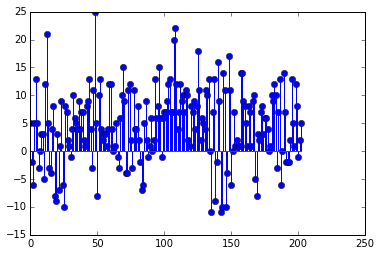

In [7]:
stem(X)

In [8]:
X_index = list(enumerate(X))
max(X_index, key=lambda e: e[1])

(48, 25)

Wir sehen, dass der Maximalwert von $X[48]=25$ an der Indexstelle $k=48$ erreicht wird. Darüber hinaus können aber auch Stellen identifiziert werden, die ähnlich gute Ergebnisse liefern.

Die [Autokorrelationsfunktion](https://de.wikipedia.org/wiki/Autokorrelation) von $P_\text{num}$ liefert einen Maximalwert von

In [9]:
sum(map(lambda e: e*e, P_num))

25

D.h. das entspricht einem perfekten Match. Wenn wir X darauf normieren, so erhalten wir eine Güte für das Matching:

In [10]:
max_match = sum(map(lambda e: e*e, P_num))
n = len(T_num)
m = len(P_num)
X = zeros(n-m+1, dtype='float')
for i in range(n-m+1):
    summe = 0.0
    for j in range(m):
        summe += T_num[i+j] * P_num[j]
    X[i] = summe/max_match

<Container object of 3 artists>

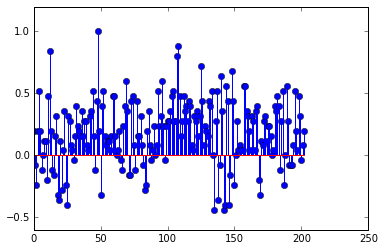

In [11]:
stem(X)

Relativ gute Matches ergeben sich auch an den Stellen

In [12]:
X_index.sort(cmp=lambda a,b: cmp(a[1], b[1]), reverse=True)
X_index[:3]

[(48, 25), (108, 22), (12, 21)]

In [13]:
align=42
for k, value in X_index[:3]:
    print("Sequenz ab k={0} (Güte: {1}): {2}".format(k, 1.0*value/max_match, T[k:k+len(P)]).rjust(align))
print("P: {0}".format(P).rjust(align-1))

  Sequenz ab k=48 (Güte: 1.0): AAAATTGCTT
Sequenz ab k=108 (Güte: 0.88): TATTTTGATT
 Sequenz ab k=12 (Güte: 0.84): ATTTATCCTG
                            P: AAAATTGCTT


Die [Hammingdistanz](https://de.wikipedia.org/wiki/Hamming-Abstand) ist die Anzahl der unterschiedlichen Stellen zweier Sequenzen:

In [14]:
def hamming(s1, s2):
    result = 0
    n1 = len(s1)
    n2 = len(s2)
    for i in range(min(n1, n2)):
        if not s1[i] == s2[i]:
            result += 1
    return result

Ergänzen wir die Hammingdistanz in unseren Ergebnissen:

In [15]:
align=62
for k, value in X_index[:3]:
    index = k
    guete = 1.0*value/max_match
    T_sub = T[k:k+len(P)]
    h_dist = hamming(T_sub, P)
    print("Sequenz ab k={0} (Güte: {1}, Hamming-Abstand: {2}): {3}".format(k, guete, h_dist, T_sub).rjust(align))
print("P: {0}".format(P).rjust(align-1))

  Sequenz ab k=48 (Güte: 1.0, Hamming-Abstand: 0): AAAATTGCTT
Sequenz ab k=108 (Güte: 0.88, Hamming-Abstand: 4): TATTTTGATT
 Sequenz ab k=12 (Güte: 0.84, Hamming-Abstand: 6): ATTTATCCTG
                                                P: AAAATTGCTT


## Fazit

Beide Verfahren können nicht mit InDels umgehen. Darüber hinaus hat beim Mapping der Basen auf Zahlen die Auswahl der Zahlen erheblichen Einfluß auf das Ergebnis der Kreuzkorrelation. (Siehe Kommentar zur Überbewertung von A und G)

Der Schlüssel einer schnellen Such liegt meiner Meinung nach darin das Refernzgenom optimal auf die Suche beliebig vieler kleiner Suchstrings vorzubereiten. Darin liegt die Annahme, dass viele Suchen auf dem Referenzgenom durchgeführt werden sollen. Die Vorbereitung dürfte dann ruhig länger dauern, solange die Suche schnell geht.

(Stimmt die Annahme?)